# Úkol č. 1 - redukce dimenzionality a binární klasifikace

  * **Deadline je 22. 4. 2024, 23:59:59**, pokud odevzdáte úkol do 29. 4. 2024, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * Experimentujte se standardizací/normalizací dat.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.


  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky a pokuste modely vylepšit
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [49]:
import pandas as pd
import numpy as np

import time

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics as metrics

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding

import matplotlib.pyplot as plt

rd_seed = 99

%matplotlib inline

Nacteme dataset ze souboru "train.csv" a uložíme ho do proměnné "pictures" jako pandas DataFrame.

In [50]:
# Load the dataset from the CSV file into a pandas DataFrame
pictures = pd.read_csv("train.csv")

In [51]:
# Print basic information about the DataFrame
pictures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 14.4 MB


Zobrazíme prvních 10 obrázků z datasetu a labelů, které jim odpovídají.

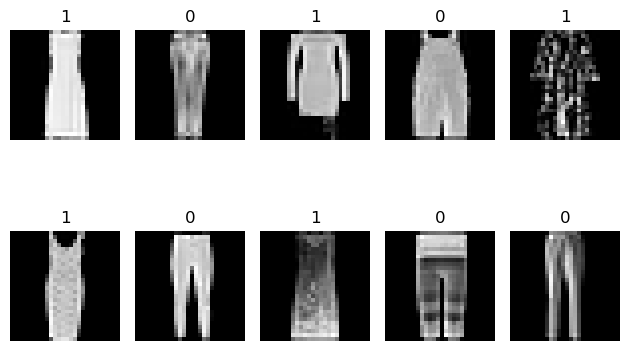

In [52]:
for i in range(0, 10):
    # Convert pixels to 28x28 format
    image = pictures.iloc[i, 1:].values.reshape(28, 28)

    # Image display
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')        
    plt.title(pictures.iloc[i, 0])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [53]:
zero_pixels = sum((pictures == 0).all())
print("The number of pixels that are completely black in all images in the dataset:", zero_pixels)

The number of pixels that are completely black in all images in the dataset: 18


* Na základě předchozí poznámky lze předpokládat, že dataset obsahuje pixely (atributy), které pravděpodobně nemají žádný vliv na to, co je na obrázku.
* Pixely s hodnotou 0 jsou plně černé pixely, které mohou například odpovídat pixelům v rozích obrázku.
* Vzhledem k tomu, že jeden pixel odpovídá jednomu atributu v našem datasetu, odstraněním některých pixelů (v případě potřeby většiny) výrazně snížíme dimenzi v našem datasetu.
* To může mít pozitivní vliv na práci modelů, které budou v této práci použity.

Nejprve provedeme některé přípravné akce:
* Data rozdělíme do tří částí: trénovací, validační a testovací v poměru 60/24/16 %.
* Vytvoříme kopie datasetu, které budou normalizovány pomocí MinMax normalizace a standartizace.
* Připravíme funkci `draw_acc()`.

In [54]:
# Split the training dataset into 60% train and 40% rest
Xtrain, Xrest, ytrain, yrest = train_test_split(pictures.drop(columns=['label']), pictures.label, test_size=0.4, random_state = rd_seed)

# Split the rest of the data into 0.6*0.4=24% validation, 0.4*0.4=16% test
Xtest, Xval, ytest, yval = train_test_split(Xrest, yrest, test_size=0.6, random_state = rd_seed)

print(f"Train rozměry, X: {Xtrain.shape}, y: {ytrain.shape}")
print(f"Val rozměry, X: {Xval.shape}, y: {yval.shape}")
print(f"Test rozměry, X: {Xtest.shape}, y: {ytest.shape}")

Train rozměry, X: (1440, 784), y: (1440,)
Val rozměry, X: (576, 784), y: (576,)
Test rozměry, X: (384, 784), y: (384,)


In [55]:
# Fit the StandardScaler to the training data
standard_scaler = StandardScaler().fit(Xtrain)

# Transform the training, validation, and test data using the fitted scaler
Xtrain_standard = standard_scaler.transform(Xtrain)
Xval_standard = standard_scaler.transform(Xval)
Xtest_standard = standard_scaler.transform(Xtest)

In [56]:
# Fit the MinMaxScaler to the training data
minMax_scaler = MinMaxScaler().fit(Xtrain)

# Transform the training, validation, and test data using the fitted scaler
Xtrain_minMax = minMax_scaler.transform(Xtrain)
Xval_minMax = minMax_scaler.transform(Xval)
Xtest_minMax = minMax_scaler.transform(Xtest)

In [57]:
def draw_acc(train_acc, val_acc):
    """
    Plots the accuracy graph for different combinations of model hyperparameters.

    Args:
        train_acc: List or array containing accuracy values for a specific combination
                   of hyperparameters on the training set.
        val_acc: List or array containing accuracy values for the same combination
                 of hyperparameters on the validation set.
    """
    plt.figure(figsize=(20,6))
    plt.plot(train_acc, 'or-')
    plt.plot(val_acc, 'ob-')
    plt.xlabel('Combination of hyperparameters')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

Pro každý model budou provedeny následující kroky:
1. Hledání optimálních hyperparametrů pro tento model. Během testování bylo vyzkoušeno mnoho různých kombinací a toto řešení bude mít pouze relativně malý počet kombinací hyperparametrů pro každý model, který bude samozřejmě obsahovat i nejlepší kombinaci. Toto rozhodnutí je učiněno tak, aby bylo možné v případě potřeby rychle znovu najít nejlepší kombinaci (nečekejte věčnost, až model vyzkouší každou kombinaci :).
2. Vizualizace dynamiky změny přesnosti modelu na validační množině v závislosti na kombinacích hyperparametrů.
3. Výpočet přesnosti modelu s "nejlepšími hyperparametry" na validační množině.
4. Komentář k výsledku.

## SVC

Výhody tohoto modelu:
   1. **Schopnost pracovat s vysokým rozměrem dat**: SVC je efektivní při zpracování dat s velkým množstvím funkcí, což je přesně případ datasetu obrázků oblečení s 784 pixely.
   2. **Flexibilita v kernelových funkcích**: SVC umožňuje použití různých kernelových funkcí, jako jsou lineární, polynomické a radiální bázové funkce, což umožňuje modelu dobře se přizpůsobit různým typům dat a jejich distribucím.
   3. **Odolnost vůči přetrénování**: SVC má výhodu odolnosti vůči přetrénování, což znamená, že i když máme velký počet trénovacích dat, model bude schopen dobře pracovat na nových datech bez přílišného snížení přesnosti.

Hledání optimálních hyperparametrů ->

In [58]:
param_grid = {
    'C' : np.arange(0.5, 15, 0.5),
    'kernel' : ['poly', 'rbf'],
    'normalization' : ['MinMax', 'Standard', 'No']
}

# Creating a parameter grid using the ParameterGrid
param_comb = ParameterGrid(param_grid)

In [59]:
val_acc = []    # List to store validation accuracy for each parameter combination
train_acc = []  # List to store training accuracy for each parameter combination

st = time.time()

# Loop through each parameter combination
for param in param_comb:
    svc_clf = SVC(C=param['C'], kernel=param['kernel'])

    # Fit the classifier to the training data based on the normalization option
    if param['normalization'] == 'MinMax':
        svc_clf.fit(Xtrain_minMax, ytrain)
        train_acc.append(metrics.accuracy_score(ytrain, svc_clf.predict(Xtrain_minMax)))
        val_acc.append(metrics.accuracy_score(yval, svc_clf.predict(Xval_minMax)))
    elif param['normalization'] == 'Standard':
        svc_clf.fit(Xtrain_standard, ytrain)
        train_acc.append(metrics.accuracy_score(ytrain, svc_clf.predict(Xtrain_standard)))
        val_acc.append(metrics.accuracy_score(yval, svc_clf.predict(Xval_standard)))
    else:
        svc_clf.fit(Xtrain, ytrain)
        train_acc.append(metrics.accuracy_score(ytrain, svc_clf.predict(Xtrain)))
        val_acc.append(metrics.accuracy_score(yval, svc_clf.predict(Xval)))

et = time.time()


In [60]:
print(f"SVC tried {len(param_comb)} combinations of params in{et - st : .03f}s")

SVC tried 174 combinations of params in 43.846s


Trvání 43.846 sekundy na vyhodnocení 174 kombinací parametrů modelu SVC bylo především způsobeno kombinací vysokého počtu parametrů, složitostí modelu SVC a výpočetní náročností vyhodnocování. 

Vizualizace dynamiky změny přesnosti modelu na validační množině v závislosti na kombinacích hyperparametrů ->

The best params for SVC: {'normalization': 'No', 'kernel': 'rbf', 'C': 8.0}


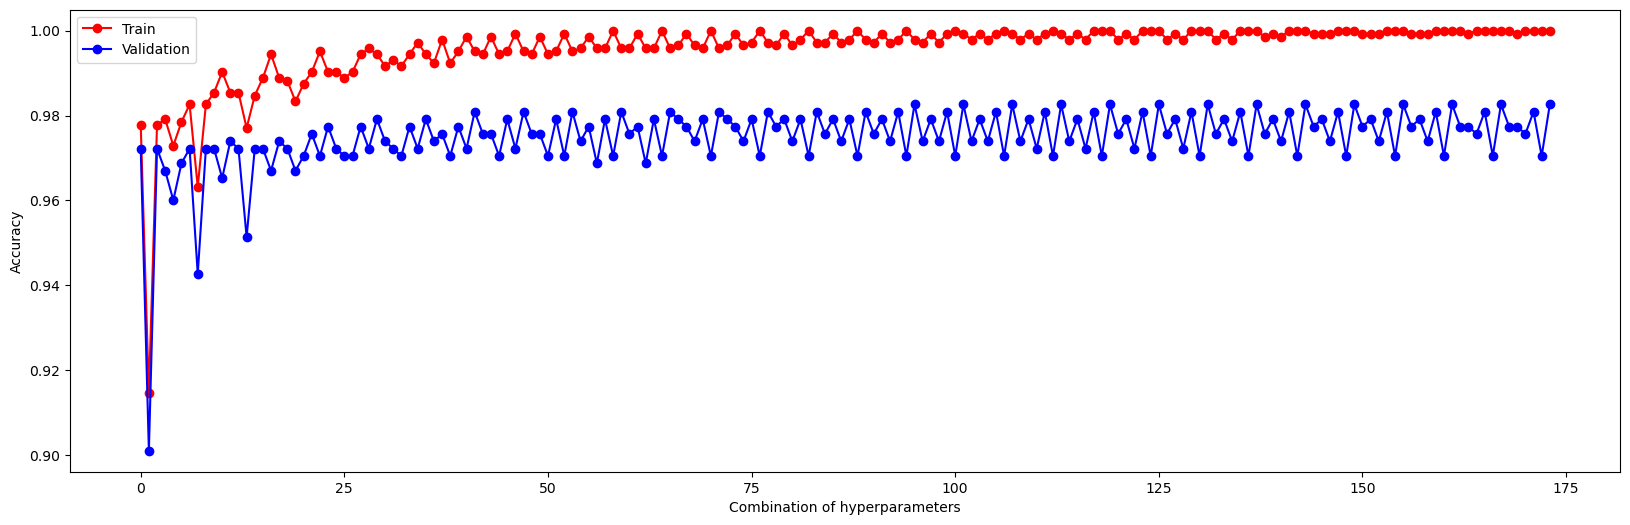

In [61]:
draw_acc(train_acc, val_acc)
best_params = param_comb[np.argmax(val_acc)]
print('The best params for SVC:', best_params)

Výpočet přesnosti modelu s "nejlepšími hyperparametry" na validační množině ->

In [62]:
st = time.time()

svc_clf = SVC(C = best_params['C'], kernel = best_params['kernel']).fit(Xtrain, ytrain)

et = time.time()
print(f"SVC - training time:{et - st : .03f}s")

svc_acc = round(metrics.accuracy_score(yval, svc_clf.predict(Xval)), 4)
print('Accuracy score (train): {0:.4f}'.format(metrics.accuracy_score(ytrain, svc_clf.predict(Xtrain))))
print(f'Accuracy score (validation): {svc_acc}')

SVC - training time: 0.106s
Accuracy score (train): 0.9979
Accuracy score (validation): 0.9826


* Tyto výsledky naznačují, že model byl trénován velmi krátkou dobu, konkrétně 0,106 sekundy. 
* Přesnost klasifikace na trénovací sadě je mimořádně vysoká, dosahuje 99,79%. 
* Navíc model dobře pracuje i na validační sadě s přesností 98,26%. 
* Tyto výsledky naznačují, že model SVC se naučil vzory v trénovacích datech velmi dobře a je schopen efektivně generalizovat na neviděná data, což dokazuje vysoká validační přesnost.

In [63]:
SV = svc_clf.support_.shape[0]
print(f"Počet podpůrných vektorů {SV} tvoří {100*SV/Xtrain_minMax.shape[0]:.1f} % trénovací množiny.")

Počet podpůrných vektorů 201 tvoří 14.0 % trénovací množiny.


* Podpůrné vektory jsou vzorky z trénovací sady, které leží na okraji rozhodovací hranice a jsou klíčové pro definici tohoto hranice. 
* Jejich poměrně malý počet, tvořící pouze zlomek celkového počtu trénovacích dat, naznačuje, že model SVC dosáhl vysoké přesnosti s minimálním počtem klíčových podpůrných vzorků.

## Gaussian Naive Bayes

Výhody tohoto modelu:
1. **Jednoduchost modelu**: GaussianNB je jednoduchý pravděpodobnostní model, snadno srozumitelný a interpretovatelný.
2. **Rychlost trénování a predikce**: Díky své jednoduché pravděpodobnostní povaze má model obvykle velmi vysokou rychlost trénování a predikce, což může být důležité při práci s velkými datovými soubory nebo potřebě rychlého nasazení modelu.
3. **Gaussovské rozdělení**: GNB předpokládá, že hodnoty funkcí jsou gaussovsky rozdělené. I když to nemusí plně odpovídat skutečnosti, může to stále poskytnout užitečný model, zejména pokud jsou hodnoty pixelů relativně normálně distribuované.

Model nemá pro nás zajímavé hyperparametry, takže si jen vyzkoušíme, jak se bude chovat po různé normalizaci dat.

In [64]:
param_grid = {
    'normalization' : ['MinMax', 'Standard', 'No']
}
param_comb = ParameterGrid(param_grid)

In [65]:
val_acc = []
train_acc = []

st = time.time()

for param in param_comb:
    GaussianNB_clf = GaussianNB()
    if param['normalization'] == 'MinMax':
        GaussianNB_clf.fit(Xtrain_minMax, ytrain)
        train_acc.append(GaussianNB_clf.score(Xtrain_minMax, ytrain))
        val_acc.append(GaussianNB_clf.score(Xval_minMax, yval))
    elif param['normalization'] == 'Standard':
        GaussianNB_clf.fit(Xtrain_standard, ytrain)
        train_acc.append(GaussianNB_clf.score(Xtrain_standard, ytrain))
        val_acc.append(GaussianNB_clf.score(Xval_standard, yval))
    else:
        GaussianNB_clf.fit(Xtrain, ytrain)
        train_acc.append(GaussianNB_clf.score(Xtrain, ytrain))
        val_acc.append(GaussianNB_clf.score(Xval, yval))

et = time.time()

In [66]:
print(f"GaussianNB tried MinMax normalisation and standardization in{et - st : .03f}s")

GaussianNB tried MinMax normalisation and standardization in 0.092s


Vizualizace výsledků ->

The best params for GaussianNB: {'normalization': 'Standard'}


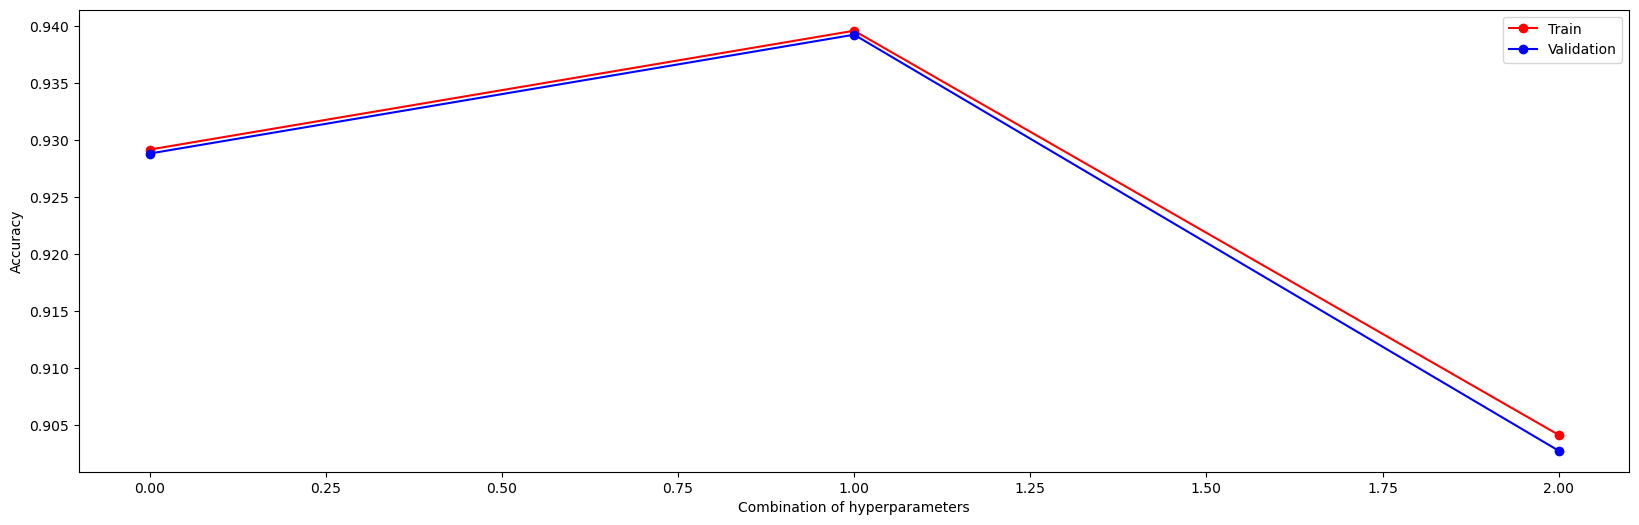

In [67]:
draw_acc(train_acc, val_acc)
best_params = param_comb[np.argmax(val_acc)]
print('The best params for GaussianNB:', best_params)

GNB předpokládá, že hodnoty příznaků jsou normálně distribuované. Standardizace dat může pomoci přiblížit distribuci hodnot k normálnímu rozdělení, což může zlepšit přesnost modelu. To je pravděpodobný důvod, proč model ukázal nejlepší výsledek na validační množině právě se standardizovanými daty.

In [68]:
st = time.time()
GaussianNB_clf = GaussianNB().fit(Xtrain_standard, ytrain)
et = time.time()
print(f"GaussianNB - taining time:{et - st : .03f}s")

nb_acc = round(GaussianNB_clf.score(Xval_standard, yval), 4)
print(f"Accuracy score (train): {round(GaussianNB_clf.score(Xtrain_standard, ytrain), 4)}")
print(f"Accuracy score (validation): {nb_acc}")
ypred = GaussianNB_clf.predict(Xval_standard)
print(f"Of the {Xval_standard.shape[0]} items in Xval_standard are poorly classified: {(yval != ypred).sum()}")

GaussianNB - taining time: 0.032s
Accuracy score (train): 0.9396
Accuracy score (validation): 0.9392
Of the 576 items in Xval_standard are poorly classified: 35


* **Spoiler**: Model s nejrychlejším trénováním.
* **Doba trénování GaussianNB**: Pouze 0,032 sekundy. Tato krátká doba trénování naznačuje, že GaussianNB je rychlý a efektivní model, který nevyžaduje dlouhou dobu trénování. Výpočetní náročnost GNB je obvykle nízká, protože model nevyžaduje složité operace nebo výpočetně náročné algoritmy. To umožňuje rychlou a efektivní implementaci algoritmu.

* **Přesnost na trénovací množině**: Dosáhla vysoké hodnoty 93,96%. To znamená, že model správně klasifikoval téměř 94% trénovacích dat, což naznačuje schopnost modelu naučit se vzory v trénovacích datech.

* **Přesnost na validační množině**: Dosáhla hodnoty 93,92%. Tato hodnota je velmi podobná přesnosti na trénovací množině, což naznačuje, že model dobře generalizuje na nová, neviděná data. Má to význam pro použití modelu v reálných podmínkách.

## LDA

Výhody tohoto modelu:
1. **Robustnost vůči multicollinearity**: LDA dokáže dobře pracovat s daty, která mají vysokou korelaci mezi rysy. To znamená, že i když jsou některé vlastnosti obrázků vzájemně závislé, LDA může stále poskytnout spolehlivé výsledky.
2. **Efektivní využití dat**: LDA se snaží maximalizovat rozdíly mezi třídami a minimalizovat rozptyl uvnitř každé třídy, což znamená, že může být efektivní při využití dostupných dat a minimalizaci rizika přeučení.

Opět model nemá pro nás zajímavé hyperparametry, takže se jen podíváme, jak se model bude chovat s normalizovanými daty.

In [69]:
val_acc = []
train_acc = []

st = time.time()

for param in param_comb:
    LDA_clf = LinearDiscriminantAnalysis()
    if param['normalization'] == 'MinMax':
        LDA_clf.fit(Xtrain_minMax, ytrain)
        train_acc.append(metrics.accuracy_score(ytrain, LDA_clf.predict(Xtrain_minMax)))
        val_acc.append(metrics.accuracy_score(yval, LDA_clf.predict(Xval_minMax)))
    elif param['normalization'] == 'Standard':
        LDA_clf.fit(Xtrain_standard, ytrain)
        train_acc.append(metrics.accuracy_score(ytrain, LDA_clf.predict(Xtrain_standard)))
        val_acc.append(metrics.accuracy_score(yval, LDA_clf.predict(Xval_standard)))
    else:
        LDA_clf.fit(Xtrain, ytrain)
        train_acc.append(metrics.accuracy_score(ytrain, LDA_clf.predict(Xtrain)))
        val_acc.append(metrics.accuracy_score(yval, LDA_clf.predict(Xval)))

et = time.time()

In [70]:
print(f"LDA tried MinMax normalisation and standardization in{et - st : .03f}s")

LDA tried MinMax normalisation and standardization in 1.445s


Vizualizace výsledků ->

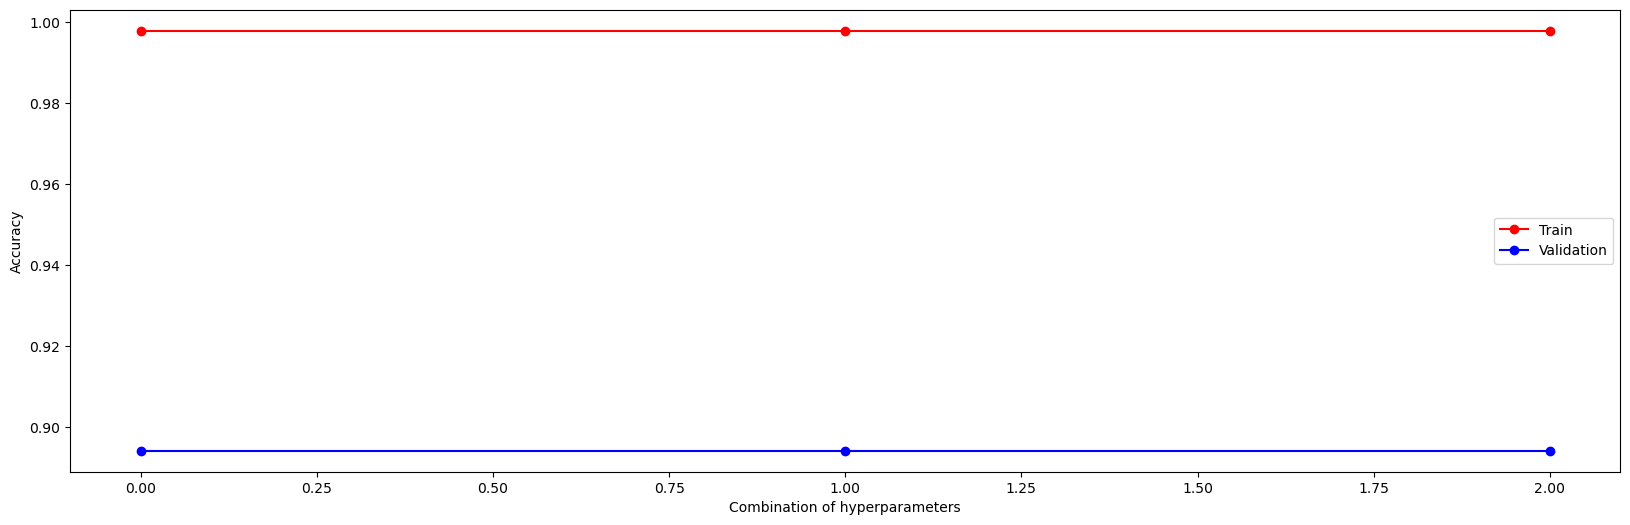

In [71]:
draw_acc(train_acc, val_acc)
best_params = param_comb[np.argmax(val_acc)]

* Na základě výsledku si můžete pouhým okem všimnout, že přesnost předpovědi modelu se v žádném případě nemění v závislosti na normalizaci dat. 
* Je to proto, že při normalizaci dat dochází k úpravě rozsahu nebo měřítka dat, ale nemění se jejich rozdělení.
* Model žádným způsobem nereaguje na normalizaci dat, protože pracuje s statistickými vlastnostmi dat, jako je průměr a kovariance, které zůstávají nezměněné při normalizaci.

In [72]:
st = time.time()
LDA_clf = LinearDiscriminantAnalysis().fit(Xtrain, ytrain)
et = time.time()
print(f"LDA - training tme:{et - st : .03f}s")

lda_acc = round(metrics.accuracy_score(yval, LDA_clf.predict(Xval)), 4)
print(f"Accuracy score (train): {round(metrics.accuracy_score(ytrain, LDA_clf.predict(Xtrain)), 4)}")
print(f"Accuracy score (validation): {lda_acc}")

LDA - training tme: 0.637s
Accuracy score (train): 0.9979
Accuracy score (validation): 0.8941


* Tréninování modelu trvalo déle než u ostatních modelů.
* Tyto výsledky naznačují, že model LDA dosáhl velmi vysoké přesnosti při trénování na trénovací sadě dat, což může být způsobeno tím, že model se naučil přesně identifikovat vzory ve trénovacích datech. 
* Nicméně, přesnost modelu na validační sadě dat je nižší, což naznačuje, že model nemusí být tak úspěšný při klasifikaci nových, neviděných dat.

## PCA

Nyní se pokusíme zlepšit schopnost generalizace modelu pomocí aplikace PCA.

Můžeme očekávat následující:
1. **Zlepšení výkonu modelu**: Redukce dimenzionality pomocí PCA může vést k lepšímu výkonu modelů tím, že odstraňuje šum nebo redundantní informace a zvýrazňuje klíčové vlastnosti dat.
2. **Snížení přeučení**: PCA může pomoci snížit přeučení modelů tím, že odstraní redundanci a šum v datech, což může vést k lepší generalizaci na nová data.
3. **Zrychlení trénování**: Snížení dimenzionality dat může vést k zrychlení trénování modelů tím, že zmenší velikost datových souborů a zjednoduší výpočetní operace.

* Průběh aplikace PCA bude podobný tomu, co jsme dělali dříve. 
* Teprve nyní budeme muset kromě hyperparametrů konkrétního modelu ladit i počet hlavních komponent (+1 hyperparametr => zhruba X-krát delší čas na nalezení optimální kombinace, kde X je počet komponent, které budou testovány).  
* Součástí vizualizace bude vždy graf, který udává, jak se liší přesnost modelu v závislosti na počtu hlavních komponent (modrá linka je nejlepším výsledkem modelu bez použití redukce dimenze).

### SVC

Hledání optimálních hyperparametrů ->

In [73]:
param_grid = {
    'C': np.arange(0.3, 21, 0.3),      
    'kernel': ['poly', 'rbf'],          
}
param_comb = ParameterGrid(param_grid)  

In [74]:
val_acc = []                        # List for validation accuracy
acc_per_components_number = {}      # Dictionary for best validation accuracy per number of PCA components
best_acc_per_components_number = 0  # The best accuracy for a specific number of PCA components
acc_for_best_params = 0             # The best accuracy for specific hyperparameters

st = time.time()

# Loop through different numbers of PCA components (from 1 to 80)
for i in range(1, 81):
    pca = PCA(n_components=i)
    X_train = pca.fit_transform(Xtrain)
    X_val = pca.transform(Xval)
    # Loop through combinations of SVC hyperparameters
    for param in param_comb:
        svc_clf = SVC(C=param['C'], kernel=param['kernel'])
        svc_clf.fit(X_train, ytrain)  
        current_val_acc = metrics.accuracy_score(yval, svc_clf.predict(X_val))  
        val_acc.append(current_val_acc)  
        # Update the best accuracy if current accuracy is higher
        if current_val_acc > best_acc_per_components_number:
            best_acc_per_components_number = current_val_acc
            # Update the best hyperparameters if current accuracy is higher than previous best
            if current_val_acc > acc_for_best_params:
                best_params = param_comb[np.argmax(val_acc)]
                acc_for_best_params = current_val_acc
    acc_per_components_number[i] = best_acc_per_components_number
    best_acc_per_components_number = 0
    val_acc.clear()

et = time.time()

In [75]:
print(f"SVC tried {len(param_comb)} combinations of params for 80 variations in the number of components in{et - st : .03f}s")

SVC tried 138 combinations of params for 80 variations in the number of components in 328.119s


Vizualizace ->

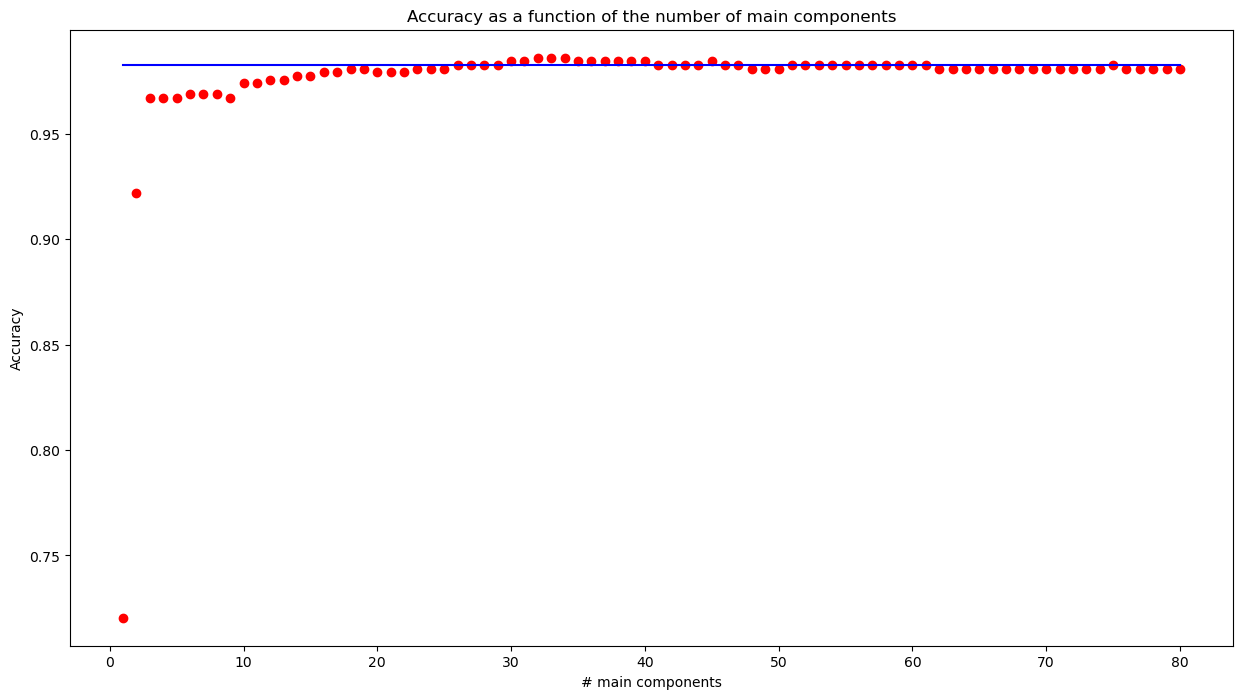

In [76]:
# Convert dictionary keys and values into lists
keys = list(acc_per_components_number.keys())
values = list(acc_per_components_number.values())

plt.subplots(1,1, figsize=(15, 8))
plt.scatter(keys, values, c='red')
plt.title(u"Accuracy as a function of the number of main components")
plt.xlabel(u'# main components')
plt.ylabel('Accuracy')
plt.plot([1, 80], [svc_acc, svc_acc],'b-')
plt.show()

Na základě grafu lze učinit zajímavou poznámku - redakce datasetu na ~3 dimenzi již má přesnost předpovědi na validační množině více než 95%!

In [77]:
print('The best params for SVC:', best_params)
best_components_number = max(acc_per_components_number, key=acc_per_components_number.get)

The best params for SVC: {'kernel': 'poly', 'C': 15.9}


In [78]:
pca = PCA(n_components=best_components_number)
X_train = pca.fit_transform(Xtrain)
X_val = pca.transform(Xval)

svc_clf = SVC(C = best_params['C'], kernel = best_params['kernel']).fit(X_train, ytrain)

pca_reduced_svc_acc = round(metrics.accuracy_score(yval, svc_clf.predict(X_val)), 4)
print('Optimal number of components:', best_components_number)
print('Accuracy score (train): {0:.4f}'.format(metrics.accuracy_score(ytrain, svc_clf.predict(X_train))))
print(f'Accuracy score (validation): {pca_reduced_svc_acc}')

Optimal number of components: 32
Accuracy score (train): 1.0000
Accuracy score (validation): 0.9861


* Výsledky ukazují, že existuje 32 pixelů, na jejichž základě lze lépe klasifikovat nové obrázky. 
* Přesnost 100% na trénovácí množině může vyvolat podezření, že model byl přetrénován. 
* Ale velmi vysoká přesnost a validační množině tato podezření vyvrátí.

### Gaussian Naive Bayes

Hledání optimálních hyperparametrů ->

In [79]:
param_grid = {
    'n_components' : range(1, 601)
}
param_comb = ParameterGrid(param_grid)

In [80]:
val_acc = []

st = time.time()

for param in param_comb:
    pca = PCA(**param)
    X_train = pca.fit_transform(Xtrain_standard)
    X_val = pca.transform(Xval_standard)
    GaussianNB_clf = GaussianNB()
    GaussianNB_clf.fit(X_train, ytrain)
    val_acc.append(GaussianNB_clf.score(X_val, yval))

et = time.time()

In [81]:
print(f"GaussinNB was looking for optimal number of components for{et - st : .03f}s")

GaussinNB was looking for optimal number of components for 709.164s


Vizualizace ->

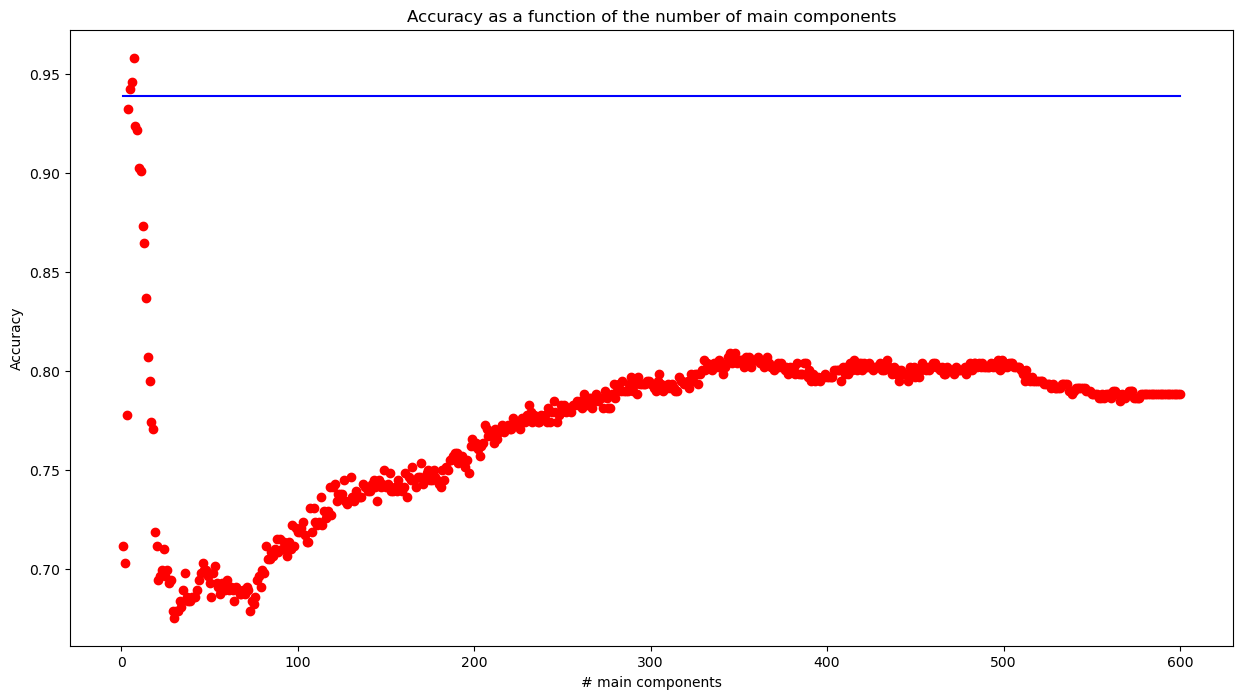

In [82]:
ACC = np.array(val_acc)
plt.subplots(1,1, figsize=(15, 8))
plt.scatter(range(1, 601), ACC, c='red')
plt.title(u"Accuracy as a function of the number of main components")
plt.xlabel(u'# main components')
plt.ylabel('Accuracy')
plt.plot([1, 600], [nb_acc, nb_acc],'b-')
plt.show()

* Z grafu je patrné, že ve většině případů při redukci dimenze v datasetu pomocí PCA model vykazuje výsledek mnohem horší než ten předchozí.
* GNB předpokládá nezávislost mezi jednotlivými atributy. Pokud jsou v datech skutečně nezávislé atributy, PCA může být neefektivní, protože snižuje dimenzionalitu dat tím, že kombinuje atributy. To může porušit předpoklad nezávislosti a vést k horšímu výkonu GNB.
* V případě 7 hlavních komponent však model dokázal dokonce zvýšit přesnost předpovědi na validační množině.

In [83]:
best_params = param_comb[np.argmax(val_acc)]
print('Optimal number of components:', best_params['n_components'])

pca = PCA(**best_params)
X_train = pca.fit_transform(Xtrain_standard)
X_val = pca.transform(Xval_standard)

GaussianNB_clf = GaussianNB().fit(X_train, ytrain)

pca_reduced_nb_acc = round(GaussianNB_clf.score(X_val, yval), 4)
print('Accuracy score (train): {0:.4f}'.format(GaussianNB_clf.score(X_train, ytrain)))
print(f'Accuracy score (validation): {pca_reduced_nb_acc}')

Optimal number of components: 7
Accuracy score (train): 0.9458
Accuracy score (validation): 0.9583


### LDA

Hledání optimálních hyperparametrů ->

In [84]:
param_grid = {
    'n_components' : range(50, 151)
}
param_comb = ParameterGrid(param_grid)

In [85]:
val_acc = []

st = time.time()

for param in param_comb:
    pca = PCA(**param)
    X_train = pca.fit_transform(Xtrain)
    X_val = pca.transform(Xval)
    LDA_clf = LinearDiscriminantAnalysis()
    LDA_clf.fit(X_train, ytrain)
    val_acc.append(metrics.accuracy_score(yval, LDA_clf.predict(X_val)))
        
et = time.time()

In [86]:
print(f"LDA was looking for optimal number of components for{et - st : .03f}s")

LDA was looking for optimal number of components for 52.866s


Vizualizace ->

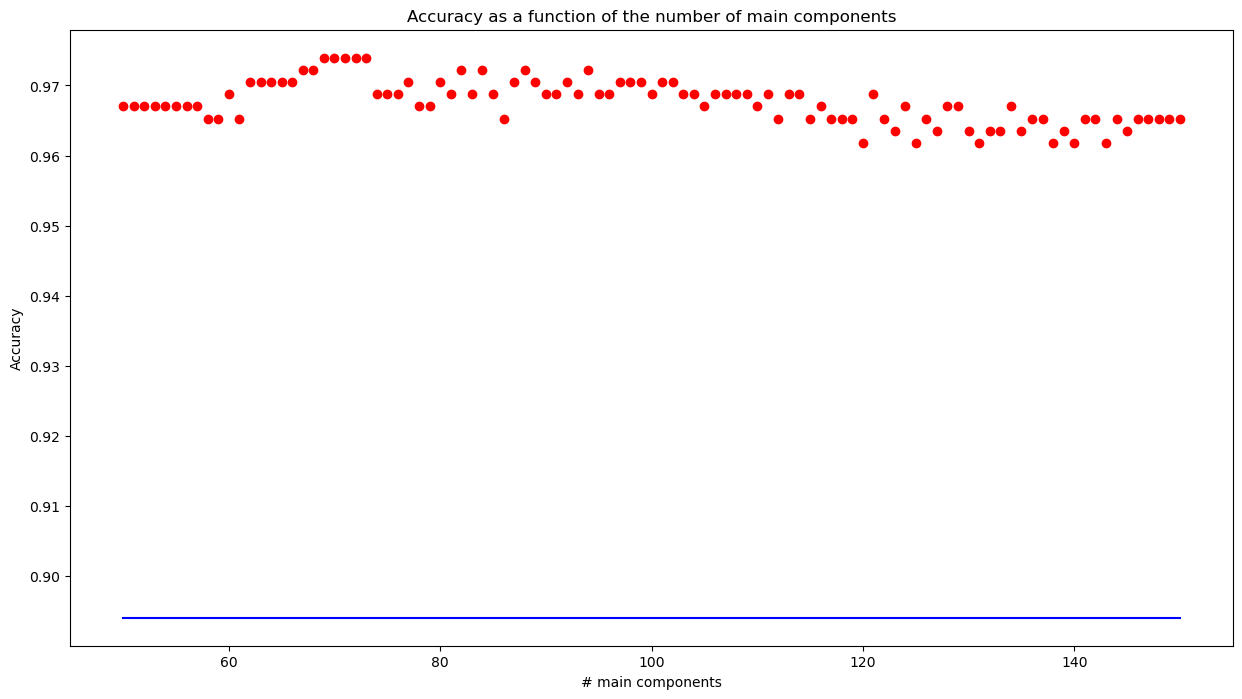

In [87]:
ACC = np.array(val_acc)
plt.subplots(1,1, figsize=(15, 8))
plt.scatter(range(50, 151), ACC, c='red')
plt.title(u"Accuracy as a function of the number of main components")
plt.xlabel(u'# main components')
plt.ylabel('Accuracy')
plt.plot([50, 150], [lda_acc, lda_acc],'b-')
plt.show()

In [88]:
best_params = param_comb[np.argmax(val_acc)]
print('Optimal number of components:', best_params['n_components'])

pca = PCA(**best_params)
X_train = pca.fit_transform(Xtrain)
X_val = pca.transform(Xval)

LDA_clf = LinearDiscriminantAnalysis().fit(X_train, ytrain)

pca_reduced_lda_acc = round(metrics.accuracy_score(yval, LDA_clf.predict(X_val)), 4)
print('Accuracy score (train): {0:.4f}'.format(metrics.accuracy_score(ytrain, LDA_clf.predict(X_train))))
print(f'Accuracy score (validation): {pca_reduced_lda_acc}')

Optimal number of components: 69
Accuracy score (train): 0.9792
Accuracy score (validation): 0.9722


* Zde naopak aplikace PCA výrazně zlepšila přesnost předpovědi na validační množině. 
* Skok o 7 procent je v našem případě obrovský. 
* Toto zlepšení může být způsobeno tím, že PCA může zvýraznit důležité vlastnosti dat tím, že zachovává informace o největších variancích. To může pomoci LDA lépe rozlišovat mezi třídami a výsledný model může být schopnější klasifikovat nová data.

## LLE

Nyní se pokusíme zlepšit schopnost generalizace modelu pomocí aplikace LLE.

Můžeme očekávat následující:
1. **Zlepšení výkonu modelu**: Redukce dimenzionality pomocí LLE může vést k lepšímu výkonu modelů.
2. **Zachování lokální struktury**: LLE se snaží zachovat lokální strukturu dat, což znamená, že podobné vzorky budou mít podobné reprezentace ve vytvořeném prostoru. To může pomoci modelům lépe rozlišovat mezi blízkými třídami a zlepšit jejich schopnost generalizace.
3. **Zrychlení trénování**: Snížení dimenzionality dat může vést k zrychlení trénování modelů tím, že zmenší velikost datových souborů a zjednoduší výpočetní operace.

* Průběh aplikace LLE bude podobný tomu, co jsme dělali dříve. 
* Je třeba prozkoumat další hyperparametr (počet sousedů). To ještě více prodlouží dobu hledání optimální kombinace hyperparametrů.
* Vizualizace bdue ukazovat dynamiku změny přesnosti modelu na validační množině v závislosti na kombinacích hyperparametrů.

### SVC

Hledání optimálních hyperparametrů ->

In [89]:
param_grid_lle = {
    'n_components' : range(1, 11),
    'n_neighbors' : range(20, 31)
}
param_grid_svc = {
    'C' : np.arange(0.2, 10, 0.2),
    'kernel' : ['poly', 'rbf'],
}
param_comb_svc = ParameterGrid(param_grid_svc)
param_comb_lle = ParameterGrid(param_grid_lle)

In [90]:
val_acc = []
lle_val_acc = []
best_acc_per_components_number = 0
acc_for_best_params = 0
best_params_svc = {}

st = time.time()

for param_lle in param_comb_lle:
    lle = LocallyLinearEmbedding(**param_lle)
    X_train = lle.fit_transform(Xtrain)
    X_val = lle.transform(Xval)
    for param_svc in param_comb_svc:
        svc_clf = SVC(**param_svc)
        svc_clf.fit(X_train, ytrain)
        current_val_acc = metrics.accuracy_score(yval, svc_clf.predict(X_val))
        val_acc.append(current_val_acc)
        if current_val_acc > best_acc_per_components_number:
            best_acc_per_components_number = current_val_acc
            if current_val_acc > acc_for_best_params:
                best_params_svc = param_comb_svc[np.argmax(val_acc)]
                acc_for_best_params = current_val_acc
    lle_val_acc.append(best_acc_per_components_number)
    best_acc_per_components_number = 0
    val_acc.clear()

et = time.time()

In [91]:
print(f"Time to find the optimal parameters for SVC and LLE:{et - st : .03f}s")

Time to find the optimal parameters for SVC and LLE: 233.910s


Vizualizace ->

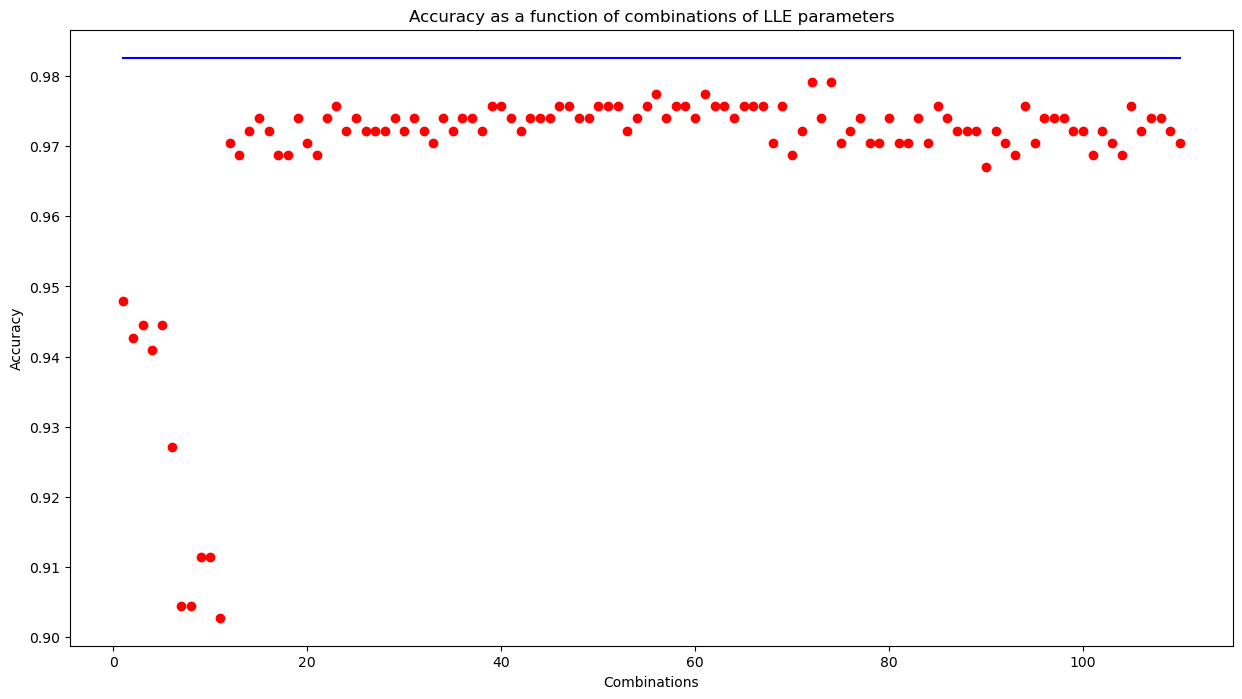

In [92]:
ACC = np.array(lle_val_acc)
plt.subplots(1,1, figsize=(15, 8))
plt.scatter(range(1, len(param_comb_lle) + 1), ACC, c='red')
plt.title(u"Accuracy as a function of combinations of LLE parameters")
plt.xlabel(u'Combinations')
plt.ylabel('Accuracy')
plt.plot([1, len(param_comb_lle)], [svc_acc, svc_acc],'b-')
plt.show()

In [93]:
print('The best params for SVC:', best_params_svc)
best_params_lle = param_comb_lle[np.argmax(lle_val_acc)]
print('The best params for LLE:', best_params_lle)

The best params for SVC: {'kernel': 'rbf', 'C': 9.6}
The best params for LLE: {'n_neighbors': 25, 'n_components': 7}


In [94]:
lle = LocallyLinearEmbedding(**best_params_lle)
X_train = lle.fit_transform(Xtrain)
X_val = lle.transform(Xval)

svc_clf = SVC(**best_params_svc).fit(X_train, ytrain)

lle_reduced_svc_acc = round(metrics.accuracy_score(yval, svc_clf.predict(X_val)), 4)
print('Accuracy score (train): {0:.4f}'.format(metrics.accuracy_score(ytrain, svc_clf.predict(X_train))))
print(f'Accuracy score (validation): {lle_reduced_svc_acc}')

Accuracy score (train): 0.9840
Accuracy score (validation): 0.9792


Po aplikaci metody LLE na datový soubor jsme pozorovali, že výsledky modelu SVC se mírně zhoršily. Možné vysvětlení tohoto výsledku může být například ztráta informace. Transformace dat pomocí LLE mohla vést ke ztrátě některých informací nebo neschopnosti zachytit klíčové aspekty dat, což mohlo negativně ovlivnit výkon modelu SVC.

### Gaussian Naive Bayes

Hledání optimálních hyperparametrů ->

In [95]:
param_grid_lle = {
    'n_components' : range(1, 21),
    'n_neighbors' : range(5, 21, 5)
}
param_comb_lle = ParameterGrid(param_grid_lle)

In [96]:
val_acc = []

st = time.time()

for param in param_comb_lle:
    lle = LocallyLinearEmbedding(**param, eigen_solver="dense")
    X_train = lle.fit_transform(Xtrain_standard)
    X_val = lle.transform(Xval_standard)
    GaussianNB_clf = GaussianNB()
    GaussianNB_clf.fit(X_train, ytrain)
    val_acc.append(GaussianNB_clf.score(X_val, yval))

et = time.time()

In [97]:
print(f"Time to find the optimal parameters for GaussianNB and LLE:{et - st : .03f}s")

Time to find the optimal parameters for GaussianNB and LLE: 31.653s


Vizualizace ->

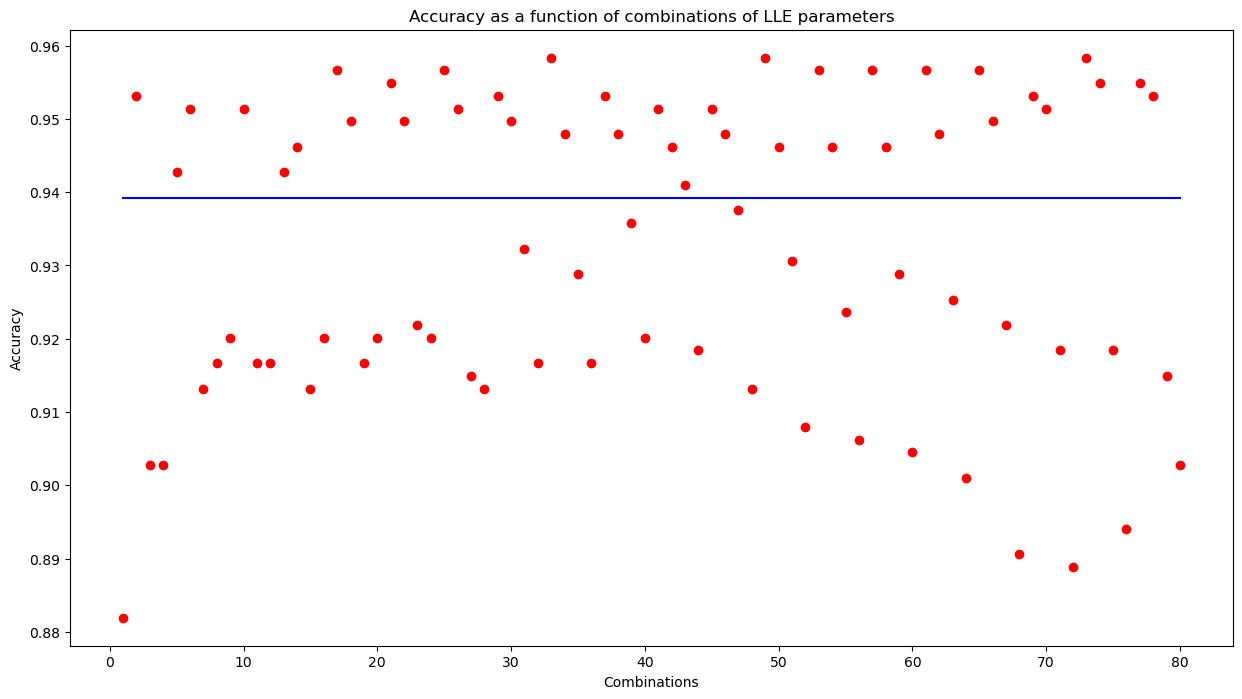

In [98]:
ACC = np.array(val_acc)
plt.subplots(1,1, figsize=(15, 8))
ns = plt.scatter(range(1, len(param_comb_lle) + 1), ACC, c='red')
plt.title(u"Accuracy as a function of combinations of LLE parameters")
plt.xlabel(u'Combinations')
plt.ylabel('Accuracy')
plt.plot([1, len(param_comb_lle)], [nb_acc, nb_acc],'b-')
plt.show()

In [99]:
best_params_lle = param_comb_lle[np.argmax(val_acc)]
print('The best params for LLE:', best_params_lle)

The best params for LLE: {'n_neighbors': 5, 'n_components': 9}


In [100]:
lle = LocallyLinearEmbedding(**best_params_lle)
X_train = lle.fit_transform(Xtrain_standard)
X_val = lle.transform(Xval_standard)

GaussianNB_clf = GaussianNB().fit(X_train, ytrain)

lle_reduced_nb_acc = round(GaussianNB_clf.score(X_val, yval), 4)
print('Accuracy score (train): {0:.4f}'.format(GaussianNB_clf.score(X_train, ytrain)))
print(f'Accuracy score (validation): {lle_reduced_nb_acc}')

Accuracy score (train): 0.9569
Accuracy score (validation): 0.9583


Porovnání s výsledky modelu Gaussian Naive Bayes bez použití LLE ukazuje, že model po aplikaci LLE dosáhl vyšší přesnosti jak na trénovací, tak na validační množině. Možné vysvětlení tohoto výsledku může být například lepší separace tříd. LLE mohla pomoci lépe separovat třídy v datech, což by mohlo vést k lepší schopnosti modelu Gaussian Naive Bayes oddělit jednotlivé třídy a vytvořit lepší klasifikační rozhodovací hranici.

### LDA

Hledání optimálních hyperparametrů ->

In [101]:
param_grid_lle = {
    'n_components' : range(1, 81),
    'n_neighbors' : range(5, 16, 5)
}
param_comb_lle = ParameterGrid(param_grid_lle)

In [102]:
val_acc = []

st = time.time()

for param in param_comb_lle:
    lle = LocallyLinearEmbedding(**param)
    X_train = lle.fit_transform(Xtrain)
    X_val = lle.transform(Xval)
    LDA_clf = LinearDiscriminantAnalysis()
    LDA_clf.fit(X_train, ytrain)
    val_acc.append(metrics.accuracy_score(yval, LDA_clf.predict(X_val)))

et = time.time()

In [103]:
print(f"Time to find the optimal parameters for LDA and LLE:{et - st : .03f}s")

Time to find the optimal parameters for LDA and LLE: 137.028s


Vizualizace ->

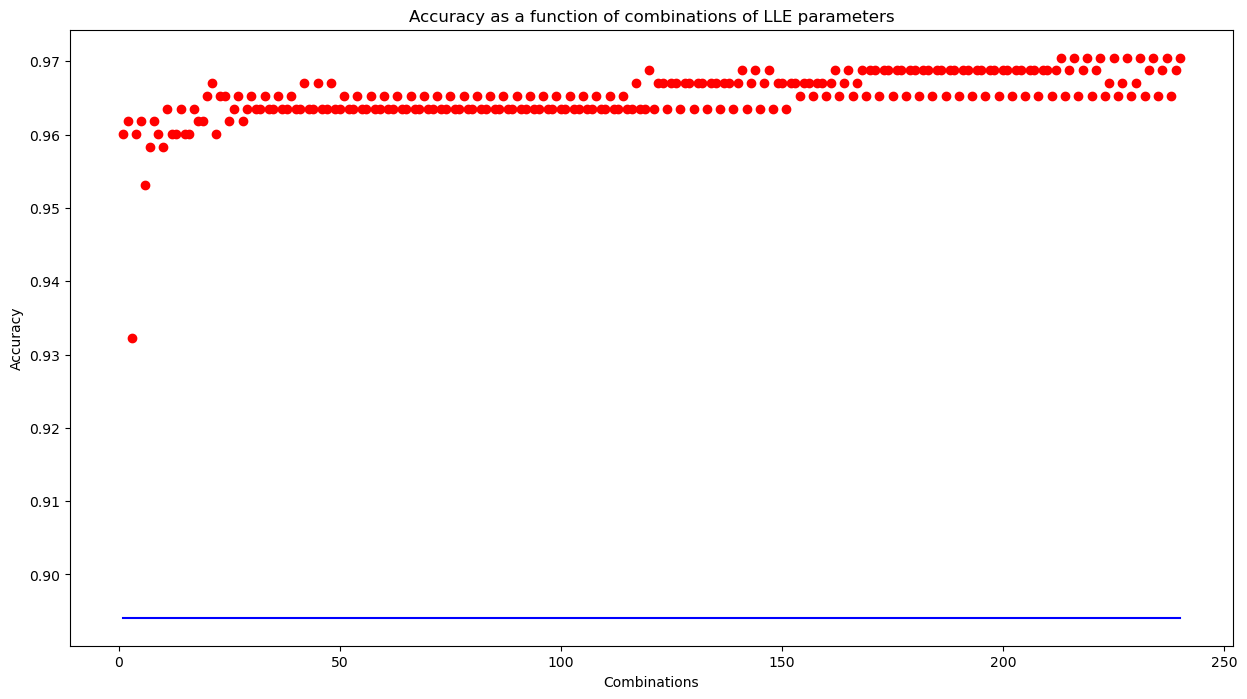

In [104]:
ACC = np.array(val_acc)
plt.subplots(1,1, figsize=(15, 8))
ns = plt.scatter(range(1, len(param_comb_lle) + 1), ACC, c='red')
plt.title(u"Accuracy as a function of combinations of LLE parameters")
plt.xlabel(u'Combinations')
plt.ylabel('Accuracy')
plt.plot([1, len(param_comb_lle)], [lda_acc, lda_acc],'b-')
plt.show()

In [105]:
best_params_lle = param_comb_lle[np.argmax(val_acc)]
print('The best params for LLE:', best_params_lle)

The best params for LLE: {'n_neighbors': 15, 'n_components': 71}


In [106]:
lle = LocallyLinearEmbedding(**best_params_lle)
X_train = lle.fit_transform(Xtrain)
X_val = lle.transform(Xval)

LDA_clf = LinearDiscriminantAnalysis().fit(X_train, ytrain)

lle_reduced_lda_acc = round(metrics.accuracy_score(yval, LDA_clf.predict(X_val)), 4)
print('Accuracy score (train): {0:.4f}'.format(metrics.accuracy_score(ytrain, LDA_clf.predict(X_train))))
print(f'Accuracy score (validation): {lle_reduced_lda_acc}')

Accuracy score (train): 0.9750
Accuracy score (validation): 0.9705


* Po testování chování modelu v závislosti především na počtu komponent lze dospět k výsledku, že přesnost modelu roste se zvyšujícím se počtem komponent. 
* Maximální hodnota přesnosti byla kupodivu při použití 784 komponent, tedy celého datasetu. 
* Aby však byla zachována hlavní myšlenka experimentu (redukce dimenze), bylo rozhodnuto stanovit horní limit počtu komponent na 80. 
* Navíc maximální přesnost tohoto modelu stále není mezi ostatními modely maximální.

## Final model

Sestavíme tabulku, která názorně ukáže výsledky přesnosti predikce na validační množině u každého modelu.

In [107]:
table = {
    'Classifier' : ['SVC', 'GaussianNB', 'LDA'],
    'Original' : [svc_acc, nb_acc, lda_acc],
    'PCA' : [pca_reduced_svc_acc, pca_reduced_nb_acc, pca_reduced_lda_acc],
    'LLE' : [lle_reduced_svc_acc, lle_reduced_nb_acc, lle_reduced_lda_acc]
}

Accuracy = pd.DataFrame(table)
print(Accuracy)

   Classifier  Original     PCA     LLE
0         SVC    0.9826  0.9861  0.9792
1  GaussianNB    0.9392  0.9583  0.9583
2         LDA    0.8941  0.9722  0.9705


Z tabulky je vidět, že nejlepším modelem je model **SVC**, který byl aplikován na dataset transformovaný pomocí metody **PCA**.

Nakonec můžeme natrénovat finální model a zjistit předpokládanou přesnost klasifikace nových obrázků.

In [108]:
pca = PCA(n_components=32)
X_train = pca.fit_transform(Xtrain)
X_test = pca.transform(Xtest)

svc_clf = SVC(kernel='poly', C=17.1).fit(X_train, ytrain)
print(f'Expected accuracy on new data (test): {round(metrics.accuracy_score(ytest, svc_clf.predict(X_test)), 4)}')

Expected accuracy on new data (test): 0.9792


Poslední kroky: 
1. Pomocí finálního modelu klasifikujeme obrázky z datasetu `evaluate.csv`. 
2. Výsledek zapíšeme do souboru `results.csv`

In [109]:
evaluate = pd.read_csv("evaluate.csv")
evaluate_index = evaluate.iloc[:, :1]
evaluate = evaluate.iloc[:, 1:]

evaluate = pca.transform(evaluate)
predict = svc_clf.predict(evaluate)

results = pd.DataFrame({'ID': evaluate_index.iloc[:, 0].ravel(), 'label': predict})
results.to_csv('results.csv', index=False)